# Bayesian modelling of football outcomes: Using the Skellam's distribution for the goal difference

Reproduction of the method outlined in *Bayesian modelling of football outcomes: Using the Skellam's distribution for the goal difference* (Karlis and Ntzoufras, 2008) <a href="https://www.researchgate.net/publication/228621612_Bayesian_modelling_of_football_outcomes_Using_the_Skellam%27s_distribution_for_the_goal_difference">link</a>).

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pystan

%matplotlib inline

In [2]:
def stan_map(vector):
    unique_items = np.unique(vector)
    number_of_unique_items = len(unique_items)
    return dict(zip(unique_items, range(1, number_of_unique_items + 1)))

In [3]:
data = (
    pd.read_csv('data/2006-07.csv')
    .assign(goal_difference=lambda df: df['FTHG'] - df['FTAG'])
    .rename(columns={'HomeTeam': 'home_team', 'AwayTeam': 'away_team'})
    [['home_team', 'away_team', 'goal_difference']]
)

team_map = stan_map(data['home_team'])
data['home_team_id'] = data['home_team'].replace(team_map)
data['away_team_id'] = data['away_team'].replace(team_map)

data.head()

,home_team,away_team,goal_difference,home_team_id,away_team_id
0,Arsenal,Aston Villa,0,1,2
1,Bolton,Tottenham,2,4,17
2,Everton,Watford,1,7,18
3,Newcastle,Wigan,1,13,20
4,Portsmouth,Blackburn,3,14,3


In [4]:
model_data = {
    'n_teams': len(data['home_team_id'].unique()),
    'n_games': len(data['goal_difference']),
    'home_team': data['home_team_id'],
    'away_team': data['away_team_id'],
    'goal_difference': data['goal_difference']
}

In [5]:
%%time 
model = pystan.StanModel('model.stan')

fit = model.sampling(
    data=model_data,
    iter=1000,
    chains=4
)

output = fit.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e08ba75958486cace3a4acac8c8406ff NOW.


CPU times: user 2.19 s, sys: 316 ms, total: 2.5 s
Wall time: 3min 59s


## Plot the output

In [6]:
# Get final league table order to reproduce the paper's plot
data['home_points'] = np.where(data['goal_difference'] > 0,
                               3, np.where(data['goal_difference'] == 0, 1, 0))
data['away_points'] = np.where(data['goal_difference'] < 0,
                               3, np.where(data['goal_difference'] == 0, 1, 0))

home_points = (
    data.groupby('home_team', as_index=False)
    .agg({'home_points': np.sum})
    .rename(columns={'home_team': 'team'})
)
away_points = (
    data.groupby('away_team', as_index=False)
    .agg({'away_points': np.sum})
    .rename(columns={'away_team': 'team'})
)

total_points = pd.merge(
    home_points, away_points
)
total_points['total_points'] = total_points['home_points'] + total_points['away_points']
total_points = total_points.sort_values(by='total_points', ascending=False).reset_index(drop=True)

# Reverse the order for plotting (lowest at the bottom)
ordered_teams = total_points['team'][::-1]

# Map ids : names for parsing Stan output
reverse_map = {v: k for k, v in team_map.items()}

In [7]:
def plot_coefficients(data, ordered_teams, title, alpha=0.05, axes_colour='black'):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    y_lookup = {i: team for i, team in enumerate(ordered_teams)}
    
    upper = 1 - (alpha / 2)
    lower = 0 + (alpha / 2)

    for i, team in y_lookup.items():
        x_mean = np.mean(data[team])
        x_lower = np.percentile(data[team], lower * 100)
        x_upper = np.percentile(data[team], upper * 100)
        
        ax.scatter(x_mean, i, alpha=1, color='black', s=25)
        ax.hlines(i, x_lower, x_upper, color='black')

    ax.set_ylim([-1, len(ordered_teams)])
    ax.set_yticks(list(y_lookup.keys()))
    ax.set_yticklabels(list(y_lookup.values()))

    # Add title
    fig.suptitle(title, ha='left', x=0.125, fontsize=18, color='k')

    # Change axes colour
    ax.spines["bottom"].set_color(axes_colour)
    ax.spines["left"].set_color(axes_colour)
    ax.tick_params(colors=axes_colour)

    # Remove top and bottom spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    
    return fig

In [8]:
reverse_map = {v: k for k, v in team_map.items()}

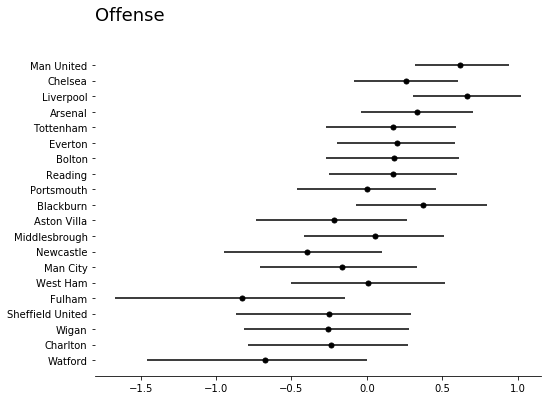

In [9]:
offense = pd.DataFrame(output['offense'])
offense.columns = [reverse_map[id_ + 1] for id_ in offense.columns]

fig_offense = plot_coefficients(offense, ordered_teams, 'Offense')
fig_offense.savefig('figures/offense.png')

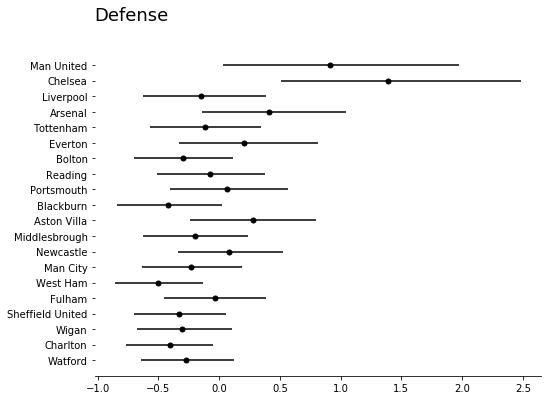

In [10]:
defense = pd.DataFrame(output['defense']) * -1
defense.columns = [reverse_map[id_ + 1] for id_ in defense.columns]

fig_defense = plot_coefficients(defense, ordered_teams, 'Defense')
fig_defense.savefig('figures/defense.png')